## 2.2 ARモデル

statsmodelを使って実装してみる。

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [118]:
import statsmodels
print(statsmodels.__version__)

0.11.1


In [4]:
df_ice = pd.read_csv("./data/icecream.csv", encoding='sjis', header=1)

# インデックスを月ごとにする
y = pd.Series(df_ice['アイスクリーム'].values,
             index=pd.date_range('2003-1', periods=len(df_ice), freq='M'))

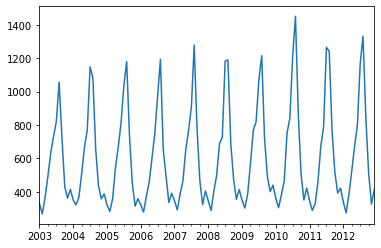

In [7]:
y.plot()

アイスクリームの消費額データが定常過程であるかどうかを調べる必要がある。  
定常過程であるかどうかは **ADF検定** により行うことができる。

モデルの構築  
訓練データ: 前半100点  
テストデータ: 後半20点

In [10]:
from statsmodels.tsa import stattools

# トレンド項あり(２次まで)、定数項ありの場合
ctt = stattools.adfuller(y[:100], regression='ctt')
# トレンド項あり(１次まで)、定数項ありの場合
ct = stattools.adfuller(y[:100], regression='ct')
# トレンド項なし、定数項ありの場合
c = stattools.adfuller(y[:100], regression='c')
# トレンド項なし、定数項なしの場合
nc = stattools.adfuller(y[:100], regression='nc')
print('ctt:')
print(ctt)
print("p = ", ctt[1])
print('ct:')
print(ct)
print("p= ", ct[1])
print('c:')
print(c)
print("p= ", c[1])
print('nc:')
print(nc)
print("p= ", nc[1])

ctt:
(-3.3089558508822066, 0.1692244861968651, 11, 88, {'1%': -4.507929662788786, '5%': -3.9012866601709244, '10%': -3.595623127758734}, 993.4892589484145)
p =  0.1692244861968651
ct:
(-1.714560199971079, 0.7444294601457553, 11, 88, {'1%': -4.065513968057382, '5%': -3.4616143302732905, '10%': -3.156971502864388}, 1002.5847722693204)
p=  0.7444294601457553
c:
(-0.6539247687694223, 0.8583259363632658, 11, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 1003.5884336394024)
p=  0.8583259363632658
nc:
(1.6310949179759076, 0.9751761218376866, 11, 88, {'1%': -2.5916151807851238, '5%': -1.944440985689801, '10%': -1.614115063626972}, 1002.1878264328066)
p=  0.9751761218376866


p値はすべて高く、単位根過程であるという仮設を棄却できない  
これにより、このデータは定常過程ではない。

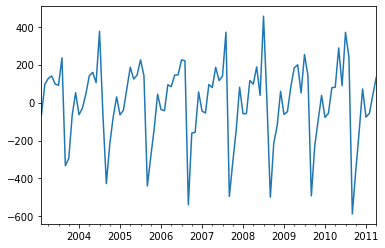

In [12]:
y_diff = y.diff()[:100].dropna()
y_diff.plot()

In [13]:
# 次は１次階差を使って定常過程かどうかを見る。
# トレンド項あり(２次まで)、定数項ありの場合
ctt = stattools.adfuller(y_diff, regression='ctt')
# トレンド項あり(１次まで)、定数項ありの場合
ct = stattools.adfuller(y_diff, regression='ct')
# トレンド項なし、定数項ありの場合
c = stattools.adfuller(y_diff, regression='c')
# トレンド項なし、定数項なしの場合
nc = stattools.adfuller(y_diff, regression='nc')
print('ctt:')
print(ctt)
print("p = ", ctt[1])
print('ct:')
print(ct)
print("p= ", ct[1])
print('c:')
print(c)
print("p= ", c[1])
print('nc:')
print(nc)
print("p= ", nc[1])

ctt:
(-20.49413879057406, 0.0, 10, 88, {'1%': -4.507929662788786, '5%': -3.9012866601709244, '10%': -3.595623127758734}, 994.1683226214956)
p =  0.0
ct:
(-20.51282538674093, 0.0, 10, 88, {'1%': -4.065513968057382, '5%': -3.4616143302732905, '10%': -3.156971502864388}, 992.6851493902557)
p=  0.0
c:
(-20.635999245555652, 0.0, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 990.9785010415186)
p=  0.0
nc:
(-20.337724459102365, 0.0, 10, 88, {'1%': -2.5916151807851238, '5%': -1.944440985689801, '10%': -1.614115063626972}, 991.6754513068397)
p=  0.0


p値が低いので、1次階差系列が定常過程であることが確認できた。  
これを使って、ARモデルを作成する。  

In [18]:
from statsmodels.tsa import ar_model

model = ar_model.AR(y_diff)

ラグの次数を赤池情報量基準(AIC)を用いて決定する。  

$$
AIC = -2l(\hat{\theta}) + 2k
$$

$l(\hat{\theta})$ : 対数尤度  
$k$: 推定するパラメタ数


情報量として、AICの他にベイズ情報量基準(BIC)もよく用いられている。  
AICでは、標本数Tが大きくなると、必要以上に複雑なモデルを過大評価する可能性がある →　実用上の問題は大きくない  
BICでは上記のような心配が起きない。  

In [17]:
ar_model.AR?

In [20]:
# ARモデルのAICの計算をする

for i in range(20):
    model = ar_model.AR(y_diff)
    results = model.fit(maxlag=i+1)
    print('lag = ', i+1, 'aic : ', results.aic)

lag =  1 aic :  10.623349835083612
lag =  2 aic :  10.605625887136187
lag =  3 aic :  10.631794365499909
lag =  4 aic :  10.653968819566964
lag =  5 aic :  10.639020494849978
lag =  6 aic :  10.497805079154896
lag =  7 aic :  10.50164556083358
lag =  8 aic :  10.347418412668333
lag =  9 aic :  10.145773136713263
lag =  10 aic :  9.547393191591683
lag =  11 aic :  8.688494352586085
lag =  12 aic :  8.726168706454176
lag =  13 aic :  8.749080458269447
lag =  14 aic :  8.787463716774608
lag =  15 aic :  8.822181088075927
lag =  16 aic :  8.861619646480914
lag =  17 aic :  8.900710667979508
lag =  18 aic :  8.712739176754758
lag =  19 aic :  8.74636247304398
lag =  20 aic :  8.766450545272324


ラグ11で最もAICが低いので、  
11辞典前までのデータとの相関が強いことが分かる  

In [23]:
# 予めfit関数にic='aic'としておけばAICに基づいた最適な次数を求めてくれる
model = ar_model.AR(y_diff)
results11 = model.fit(maxlag=12, ic='aic')

results11.k_ar

11

<BarContainer object of 88 artists>

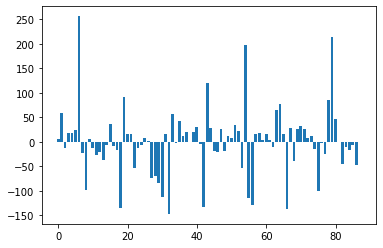

In [26]:
# 残差
res11 = results11.resid

# 残渣の出力
plt.bar(range(len(res11)), res11)

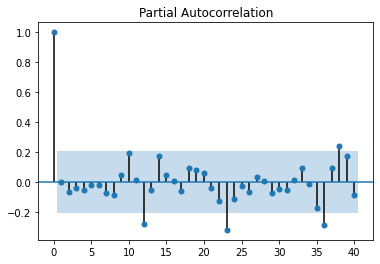

In [30]:
# 偏自己相関を確認
from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res11, lags=40)
plt.show()

ラグ12において、有意に自己相関が残っているので、AR(11)モデルが1次階差系列にある12ヶ月の周期性を十分に表現できていないことが分かる

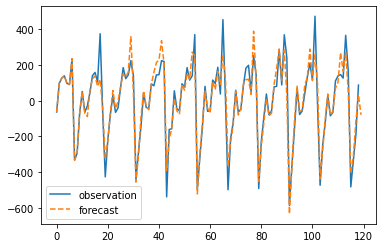

In [35]:
# 長期予測の結果を可視化する
plt.plot(y.diff().dropna().values, label='observation')

# 1時点から11時点の原系列、モデルのあてはめに使用したデータ
# AR(11)をモデルによる推定値を連結した結果の表示
plt.plot(np.hstack([y_diff[:11],
                   results11.fittedvalues,
                   results11.predict(98-11, 107, dynamic=True)]),
        '--', label='forecast')
plt.legend()

In [36]:
results11.fittedvalues

2004-01-31    -70.698524
2004-02-29    -88.133058
2004-03-31     58.340354
2004-04-30    122.597653
2004-05-31    140.214788
                 ...    
2010-12-31     82.009691
2011-01-31    -61.113872
2011-02-28    -51.109850
2011-03-31     87.615880
2011-04-30    132.661170
Freq: M, Length: 88, dtype: float64

以下のような線形モデルを考える  

$$
y_t = \sum_{i=1}^{p} \phi_i x_{t-1} + \epsilon_t,\ \epsilon_t \sim W.N.(\sigma^2)
$$

$E[y_t|\boldsymbol{x}] = \sum_{i=1}^{p} \phi_i x_{t-1}$ (条件付き期待値)  
$E[y] = \mu = \frac{1}{T}\sum_{i=1}^{T}y_i$ (無条件期待値)  

OLSを用いた尤度については以下の通り。  

$$
無条件  :  L(\mu, \sigma^2) = -\frac{T}{2}(2\pi \sigma^2) - \frac{1}{2} \sum_{t=1}^{T} \frac{(y_t -\mu)^2)}{\sigma^2} \\
条件付き :  L(\beta, \sigma^2) = -\frac{T}{2}(2 \pi \sigma^2) - \frac{1}{2}\sum_{t=1}^{T}\frac{(y_t - \sum_{i=1}^{p} \phi_i x_{t-1})^2)}{\sigma^2}
$$

## 2.3 MAモデル

ある時点の出力が過去および現在のホワイトノイズの線形和で表される場合、これを **移動平均モデル** と呼ぶ。  

1次のMA過程は以下の通り。   

$$
y_t = \mu + \epsilon_t + \theta_{1} \epsilon_{t-1}, \ \epsilon_t \sim W.N.(\sigma^2)
$$

$$
\gamma_0 = Var[y_t] \\
= Var[\mu + \epsilon_t + \theta_{1}\epsilon_{t-1}] \\
= Var[\epsilon_t] + \theta_1^2 Var[\epsilon_{t-1}] + 2\theta_1 Cov[\epsilon, \epsilon_{t-1}] \\
= (1 + \theta_1^2)\sigma^2
$$

$$
\gamma_1 = \theta_1 \sigma^2  \\
\rho_1 = \frac{\gamma_1}{\gamma_0} = \frac{\theta_1}{1 + \theta_1^2}
$$

1次自己相関の値は0.5を超えることがない。

$2\leq k$のときの自己共分散の値は

$$
\gamma_k = Cov[y_t, y_{t-k}] \\
= Cov[\mu + \epsilon_t + \theta_1 \epsilon_{t-1},  \mu + \epsilon_{t-k} + \theta_1 \epsilon_{t-k} ] \\
= 0 
$$

MA(1)過程を2次以降のMA(q)過程とすると、次のように定義される。  

$$
y_t = \mu + \epsilon_t + \sum_{i=1}^{q}\theta_i\epsilon_{t-i},\ \epsilon_t \sim W.N.(\sigma^2) \\
$$

MAモデルは常に定常な過程として扱われる。

## 2.4 ARMAモデル

**自己回帰移動平均モデル**についての説明。  

$$
y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t - \sum_{i=1}^{q}\theta_i \epsilon_{t-i},\ \epsilon_t \sim W.N.(\sigma^2) \\
$$

ARモデルは非定常、MAモデルは定常。

1. ARMAモデルの期待値はARモデルにおける期待値と等しくなる(ホワイトノイズの期待値が0であるため)  

$$
y = E[y_t] = \frac{c}{1 - \sum_{i=1}^{p}\phi_i}
$$

2. q+1次以降の自己共分散 $\gamma_i$ と自己相関 $\rho_k$ は、$y_t$ が従うARMA過程のAR部分と同一の係数をもつ以下のp次差分方程式に従う(ユール・ウォーカー方程式)  

$$
\gamma_k = \sum_{i=1}^{p}\phi_i \gamma_{k-i},\ k \geq q + 1 \\
\rho_k = \sum_{i=1}^p \phi \rho_{k-i}, \ k \geq q + 1
$$

3. ARMA過程の自己相関は次数に関して指数的に減衰する。

In [39]:
from statsmodels.tsa import stattools

# 次数選択の情報量基準にAICとBICを使う
info_criteria = stattools.arma_order_select_ic(y_diff, ic=['aic', 'bic'])
# AICとBICが最小になる次数をそれぞれ表示
info_criteria.aic_min_order, info_criteria.bic_min_order

/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


((4, 2), (4, 2))

In [41]:
# ARMAモデルの当てはめ
from statsmodels.tsa.arima_model import ARMA
# p=4, q=2のARMAモデルのインスタンスを生成
model = ARMA(y_diff, (4, 2))
# y_diffに対してモデルをあてはめる
results = model.fit()

/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<BarContainer object of 99 artists>

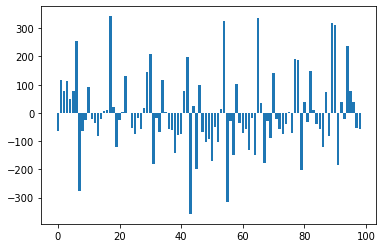

In [42]:
# 残差の抽出
res = results.resid
# 残差の出力
plt.bar(range(len(res)), res)

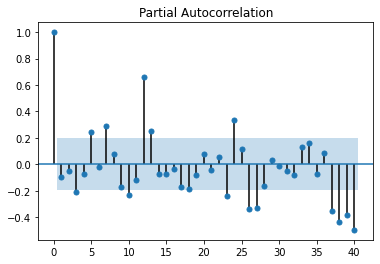

In [45]:
from statsmodels.graphics import tsaplots # 偏自己相関の確認をする

tsaplots.plot_pacf(res, lags=40)
plt.show()

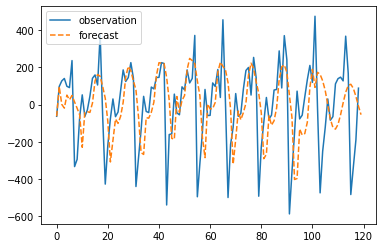

In [47]:
# 1次回差系列の表示
plt.plot(y.diff().dropna().values, label='observation')
# ARMA(4, 2)による推定値の表示
plt.plot(np.hstack([y_diff[:2],
                  results.fittedvalues,
                  results.predict(99-2, 115, dynamic='True')]),
        '--', label='forecast')
plt.legend()

結果を見てみると、やはり少々フィッティングがうまくいっていないように見える

## 2.5 ARIMAモデル

**自己回帰和分移動平均モデル**  
トレンドを除去して定常過程に変換する手法がARMAに加わっている。

- 和分過程: d-1階差分をとった系列は非定常過程であるが、d階差分をとった系列が定常が過程に従う過程は、d次和文過程もしくはI(d)過程と呼ばれる。  
- ARIMA過程: d階差分をとった系列が定常化tう反転可能なARMA(p, q)過程に従う過程には次数(p, d, q)のARIMA過程もしくはARIMA(p, d, q)と呼ばれる。  

In [48]:
import requests
import io

url = 'https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv'
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))

df_content = content.copy()

In [49]:
df_content

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


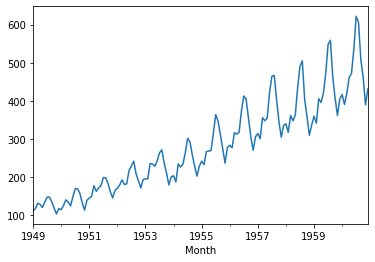

In [50]:
df_content['Month'] = pd.to_datetime(df_content['Month'],
                                    infer_datetime_format=True)
y = pd.Series(df_content['#Passengers'].values, index=df_content['Month'])
y = y.astype('f')
y.plot()

/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<BarContainer object of 119 artists>

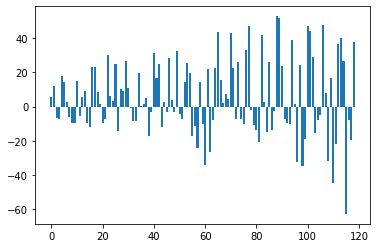

In [51]:
# 階差をとらずにモデルを構築して、長期予測の際にトレンドが捉えられているかどうかを確認する。  

from statsmodels.tsa.arima_model import ARIMA

# yは上のコードで取得した月ごとの旅客機の乗客数データ
y120 = y[:120]
# 階差をとらないモデル(p=3, d=0, q=2)
model_d0 = ARIMA(y120, (3, 0, 2))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid

# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

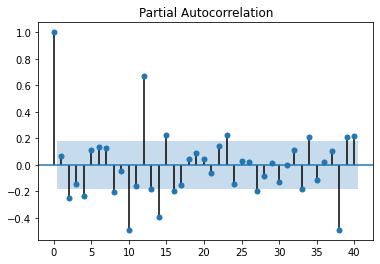

In [53]:
from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res_d0[1:], lags=40)
plt.show()

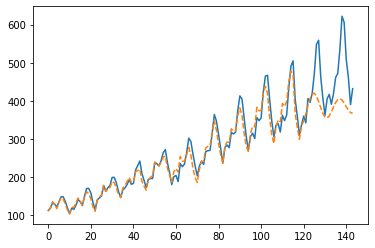

In [54]:
# 予測結果と原系列の比較
plt.plot(y.values, label='observation')

# インサンプル(学習に使ったサンプルデータ)と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルのときとpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)).values,
        '--', label='forecast')

/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<BarContainer object of 119 artists>

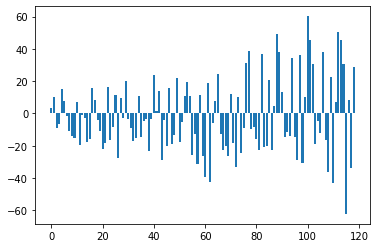

In [55]:
# 階差1をとったモデル(p=4, d=1, q=1)
model_d1 = ARIMA(y120, (4, 1, 1))
results_d1 = model_d1.fit()
res_d1 = results_d1.resid

# 残差の出力
plt.bar(range(len(res_d1)), res_d1)

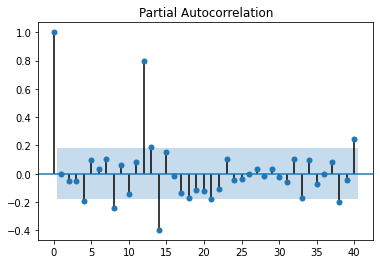

In [57]:
tsaplots.plot_pacf(res_d1, lags=40)
plt.show()


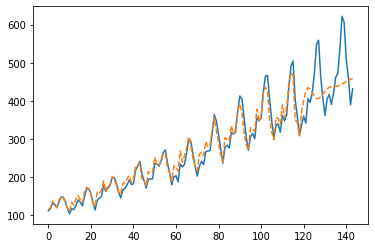

In [60]:
plt.plot(y.values, label='lbservation')

# 階差をとっているためインサンプルを元データの形に戻すため、
# typオプションに'levels'を指定している
plt.plot(results_d1.predict(1, len(y),typ='levels').values,
        '--', label='forecast')

In [63]:
def create_data(data_length, ar1=1, set_std=1, y0=0, random_seed=555):
    np.random.seed(random_seed)
    cur_y = y0
    val_list = []
    y_t2 = 0
    e_m1 = np.random.normal(loc=0, scale=set_std)
    for i in range(data_length):
        val_list.append(cur_y)
        if i > 0:
            y_t2 = val_list[-2]
        e_0 = np.random.normal(loc=0, scale=set_std)
        cur_y = 0.5 + cur_y + ar1 * (cur_y - y_t2) - 2*e_m1
        e_m1 = e_0
    return val_list

In [97]:
data = create_data(150, ar1=1, set_std=30, y0 = 0)

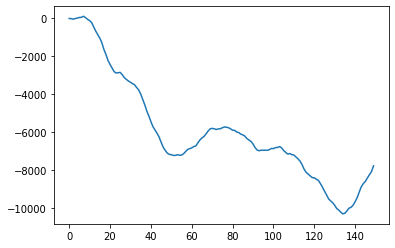

In [98]:
plt.plot(data)

<BarContainer object of 119 artists>

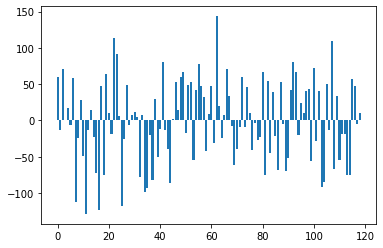

In [99]:
model_d1 = ARIMA(data[:120], (4, 1, 1))
results_d1 = model_d1.fit()
res_d1 = results_d1.resid

# 残差の出力
plt.bar(range(len(res_d1)), res_d1)

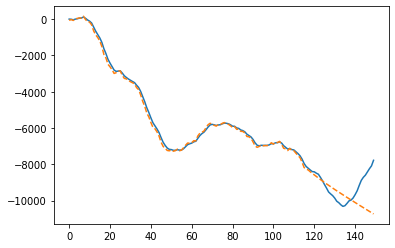

In [100]:
plt.plot(data, label='lbservation')

# 階差をとっているためインサンプルを元データの形に戻すため、
# typオプションに'levels'を指定している
plt.plot(results_d1.predict(1, len(data),typ='levels'),
        '--', label='forecast')

## 2.6 SARIMAモデル

季節変動要因について考慮する。  
**季節変動自己回帰和分移動平均モデル**  


SARIMA(p, d, q; P, D, Q, s)過程

$$
\phi(B)\phi_s(B) \Delta^d \Delta_s^D y_t = \theta (B) \theta_s (B) \epsilon_t \\
\phi(B) = 1 - \sum_{i=1}^p \phi_i B^i \\
\phi_s(B) = 1- \sum_{i=1}^P \phi_{s_i} B^{si} \\
\theta(B) = 1 + \sum_{i=1}^q \theta_i B^i \\
\theta_s(B) = 1 + \sum_{i=1}^Q \theta_{s_i} B^{si} \\
$$

B^n =  y(t-n) / y_t


/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


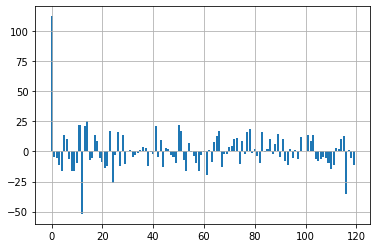

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, sp, sd, sq = 2, 1, 2, 1, 1, 1
seasonal = 12

# SARIMAX(p=2, d=1, q=2; P=1, Q=1, s=12)モデルのあてはめ
result = SARIMAX(
    y120, order=(p, d, q),
    seasonal_order=(sp, sd, sq, seasonal),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit()

# 残差の抽出
res = result.resid
# 残差の出力
plt.bar(range(len(res)), res)
plt.grid()

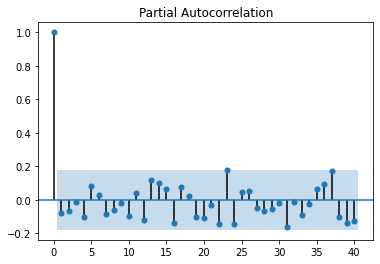

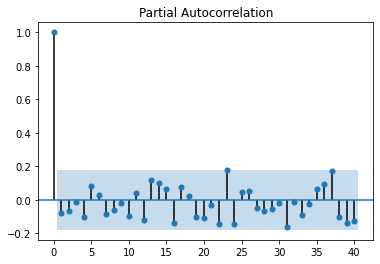

In [104]:
from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res, lags=40)

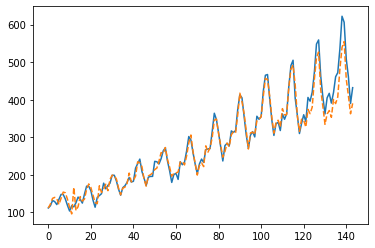

In [110]:
plt.plot(y.values, label='observation')
plt.plot(np.hstack([y120[0],
                   result.fittedvalues[1:],
                   result.forecast(24)]),
        '--', label='forecast')

## 2.7 単位根過程

定常性を持たないデータに対して有効とされる

**単位根過程** : 原系列 $y_t$ が非定常過程であり、差分系列 $\Delta y_t = y_t - y_{t-1}$ が定常過程であるときに、過程は単位根過程であると言われる。

$$
E[y_t] = (\sum_{i=0}^{t-2}\phi_1^i)c + \phi_1^{t-1}y_1 \\
Var[y_t] = \sigma^2 \sum_{i=0}^{t-2} \phi_1^{2i}  \\
$$

$|\phi_1| = 1$ のときのみを考えれば十分になる。(このとき単位根過程)

### ランダムウォークについて

$$
y_t = y_{t-1} + \epsilon_t, \ \epsilon_t \sim W.N.(\sigma^2) \\
$$

これは以下のように書き換えられる。  

$$
y_t = y_t + \sum_{i=1}^t \epsilon_i \\
$$

### 2.7.2 単位根検定  

ADF(.. Dickey-Fuller)検定(DF検定を一般化したもの)について説明する。  

時系列が以下のAR(p)過程に従うことを仮定する。  

$$
y_t = \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t, \ \epsilon_t \sim W.N.(\sigma^2) \\
$$

AR特性方程式はz=1を解として持つ。  
そのため、  

$$
\sum_{i=1}^p \phi_i = 1 
$$

を検定する必要があるが、実際には以下のように変形した式を用いる。  

$$
y_t = \rho y_{t-1} + \sum_{i=1}^{p-1} \zeta_i \Delta y_{t-1} + \epsilon_t \\
\rho - \sum_{i=1}^{p}\phi_i \\
\zeta_k = - \sum_{i=k+1}^{p}\phi_i,\ k=1,2,\cdots, p-1 \\
$$

ARの特性方程式は以下の通り。  

$$
1 - \sum_{i=1}^p \phi_i z^i = 0 \\
$$

帰無仮説 $H_0$ : $\rho=1$ (ランダムウォーク)  
対立仮説 $H_1$ : $0 < \rho < 1$ (弱定常)

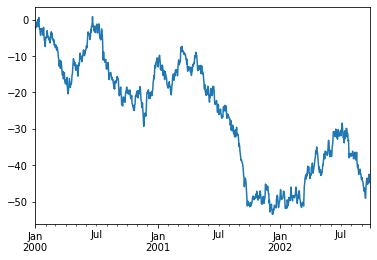

In [111]:
# ランダムウォークでの検定を行う。  
y = pd.Series(np.random.randn(1000),
             index=pd.date_range('2000-1-1', periods=1000))
y = y.cumsum()
y.plot()
plt.show()

In [113]:
from statsmodels.tsa import stattools

# ADF検定
# トレンド項あり(２次まで)、定数項あり
ctt = stattools.adfuller(y, regression='ctt')
# トレンド項あり(1次まで), 定数項あり
ct = stattools.adfuller(y, regression='ct')
# トレンド項なし、定数項あり
c = stattools.adfuller(y, regression='c')
# トレンド項なし、定数項なし
nc = stattools.adfuller(y, regression='nc')
print('ctt:')
print(ctt)
print("p = ", ctt[1])
print('ct:')
print(ct)
print("p = ", ct[1])
print('c:')
print(c)
print("p = ", c[1])
print('nc:')
print(nc)
print("p = ", nc[1])

ctt:
(-1.8600076539153525, 0.8651118892921967, 0, 999, {'1%': -4.382766025596549, '5%': -3.8383142452686947, '10%': -3.5569286306152224}, 2826.5608547561105)
p =  0.8651118892921967
ct:
(-1.8314902420824652, 0.6893796124811696, 0, 999, {'1%': -3.967860781661831, '5%': -3.4148938944043334, '10%': -3.1296421434972537}, 2824.680629374545)
p =  0.6893796124811696
c:
(-1.2458996102749715, 0.6535459865600948, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2824.4290498072287)
p =  0.6535459865600948
nc:
(0.4857062540683755, 0.8215764792830493, 0, 999, {'1%': -2.5679816723029334, '5%': -1.9412722092921209, '10%': -1.6165568281300424}, 2825.379904116471)
p =  0.8215764792830493


すべてのパターンにおいて、p値が高いので定常過程であるという帰無仮説を棄却できない。  
ここから、ランダムウォークは単位根過程であると結論づけることができる。  

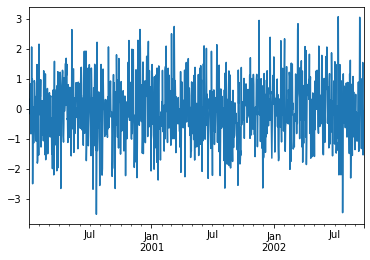

In [114]:
# 差分系列に対してADF検定を実行
y_diff = y.diff().dropna()
y_diff.plot()
plt.show()

In [115]:
# ADF検定
from statsmodels.tsa import stattools

# ADF検定
# トレンド項あり(２次まで)、定数項あり
ctt = stattools.adfuller(y_diff, regression='ctt')
# トレンド項あり(1次まで), 定数項あり
ct = stattools.adfuller(y_diff, regression='ct')
# トレンド項なし、定数項あり
c = stattools.adfuller(y_diff, regression='c')
# トレンド項なし、定数項なし
nc = stattools.adfuller(y_diff, regression='nc')
print('ctt:')
print(ctt)
print("p = ", ctt[1])
print('ct:')
print(ct)
print("p = ", ct[1])
print('c:')
print(c)
print("p = ", c[1])
print('nc:')
print(nc)
print("p = ", nc[1])

ctt:
(-30.699700805942786, 0.0, 0, 998, {'1%': -4.382777721611994, '5%': -3.8383201941769736, '10%': -3.556932312045306}, 2826.947549604387)
p =  0.0
ct:
(-30.714698307627284, 0.0, 0, 998, {'1%': -3.9678699195021783, '5%': -3.414898316296852, '10%': -3.129644744825171}, 2824.979042636403)
p =  0.0
c:
(-30.72774312576347, 0.0, 0, 998, {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}, 2823.0281470325363)
p =  0.0
nc:
(-30.69094620317038, 0.0, 0, 998, {'1%': -2.5679839221127625, '5%': -1.9412724853659513, '10%': -1.6165565671073312}, 2822.536644628325)
p =  0.0


p値が0に近いため、単位根過程ではない。 →　定常過程である

## 2.8 VARモデル

ほか系列の変数も特徴量として含めて推定する。  
ARモデルを多系列に拡張したもの。  

$$
\boldsymbol{y_t} = \boldsymbol{c}  + \sum_{i=1}^{p} \boldsymbol{\Phi}_i \boldsymbol{y}_{t-i} + \boldsymbol{\epsilon}_t, \ \boldsymbol{\epsilon}_t \sim W.N.(\boldsymbol{\Sigma}) \\
$$

$\boldsymbol{\Phi}_i \in \mathbb{R}^{n\times n}$ : 係数行列  
$\boldsymbol{c} \in \mathbb{R}^{c \times 1}$ : 定数ベクトル  
$\boldsymbol{\Sigma} \in \mathbb{R}^{n\times n}$: 分散共分散行列

特性方程式は以下の通り  

$$
|\boldsymbol{I_n} - \sum_{i=1}^p \boldsymbol{\Phi}_i \boldsymbol{z}^i | = 0
$$

上記の方程式の解の絶対値のすべてが１より大きいことがVARモデルの定常条件。

$$
\boldsymbol{\mu} = E[\boldsymbol{y}_t] = (\boldsymbol{I}_n = \sum_{i=1}^{p} \boldsymbol{\Phi}_i)^{-1} \boldsymbol c \\
$$
自己共分散は
$$
\boldsymbol{\Gamma} = \sum_{i=1}^{p} \boldsymbol{\Phi}_i \boldsymbol{\Gamma}_{k-i} \\
$$

In [117]:
import statsmodels.api as sm

df_data = sm.datasets.macrodata.load_pandas().data
df_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [119]:
# indexを月日に変換
df_data.index = pd.date_range('1959', periods=df_data.shape[0], freq='Q')
# 必要なカラムのみを取得
y = df_data[['realgdp', 'realcons', 'realinv']]

In [123]:
from statsmodels.tsa import stattools

# ADF検定
ctt_realgdp = stattools.adfuller(y.realgdp, regression='ctt')
ctt_realcons = stattools.adfuller(y.realcons, regression='ctt')
ctt_realinv = stattools.adfuller(y.realinv, regression='ctt')

print('ctt realgdp:')
print(ctt_realgdp)
print("ctt realcons:")
print(ctt_realcons)
print("ctt realinv:")
print(ctt_realinv)

ctt realgdp:
(-2.2316255634408613, 0.7145024076165511, 12, 190, {'1%': -4.433161444379647, '5%': -3.8638358600379066, '10%': -3.572676939641347}, 2030.9096153927815)
ctt realcons:
(-3.0087027982374197, 0.2910505147103153, 3, 199, {'1%': -4.430309046694293, '5%': -3.8623972900169137, '10%': -3.5717916732395594}, 1787.2221616792606)
ctt realinv:
(-1.63192154661618, 0.9226177810403438, 3, 199, {'1%': -4.430309046694293, '5%': -3.8623972900169137, '10%': -3.5717916732395594}, 1945.7305980020012)


結果を見てみると、それぞれのp値が高いので定常過程ではない。  

In [124]:
# 2次の階差をとって、定常過程に変換を試みる
y_diff = y.diff().diff().dropna()

# ADF検定
ctt_realgdp = stattools.adfuller(y_diff.realgdp, regression='ctt')
ctt_realcons = stattools.adfuller(y_diff.realcons, regression='ctt')
ctt_realinv = stattools.adfuller(y_diff.realinv, regression='ctt')

print('ctt realgdp:')
print(ctt_realgdp)
print("ctt realcons:")
print(ctt_realcons)
print("ctt realinv:")
print(ctt_realinv)

ctt realgdp:
(-5.7307111708532315, 4.5129005984889235e-05, 14, 186, {'1%': -4.434519413562635, '5%': -3.864520481428023, '10%': -3.5730981406825575}, 2025.6464949041335)
ctt realcons:
(-16.930875191757355, 7.34261860797005e-25, 1, 199, {'1%': -4.430309046694293, '5%': -3.8623972900169137, '10%': -3.5717916732395594}, 1792.6484152650387)
ctt realinv:
(-8.246099384701978, 8.39040862417975e-11, 7, 193, {'1%': -4.432180562792867, '5%': -3.8633412462204713, '10%': -3.5723725968816216}, 1936.5507934933223)


In [126]:
# 上記の検定結果より、P値が低いので単位根過程でなくなったことがわかる。  
# 2次階差系列を使ったVARモデルを作成する
from statsmodels.tsa.api import VAR

model_diff = VAR(y_diff)

# 最適なハイパラの探索
model_diff.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,22.00,22.05,3.570e+09,22.02
1,21.20,21.40,1.607e+09,21.28
2,20.73,21.09*,1.007e+09,20.87
3,20.61,21.12,8.953e+08,20.82*
4,20.58,21.25,8.701e+08,20.85
5,20.55,21.37,8.406e+08,20.88
6,20.59,21.56,8.748e+08,20.98
7,20.61,21.74,8.983e+08,21.07
8,20.50,21.77,8.009e+08,21.01
9,20.49*,21.92,7.995e+08*,21.07


In [127]:
result_diff = model_diff.fit(maxlags=10, ic='aic')
result_diff.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Apr, 2020
Time:                     15:23:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    21.9079
Nobs:                     192.000    HQIC:                   21.0600
Log likelihood:          -2699.66    FPE:                7.91212e+08
AIC:                      20.4828    Det(Omega_mle):     5.25930e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.352231         3.570180            0.099           0.921
L1.realgdp         -1.247885         0.162953           -7.658           0.000
L1.realcons         1.084603         0.212161            5.112    

In [128]:
# ARの次数を確認する
result_diff.k_ar

9

**予測誤差分散分解**(FEVD)を用いて、i時点先予測時の誤差の起因の程度を分解する。  
詳しくは他の文献を参照とのこと。

In [129]:
fevd_diff = result_diff.fevd(4)
fevd_diff.summary()

FEVD for realgdp
      realgdp  realcons   realinv
0    1.000000  0.000000  0.000000
1    0.892571  0.096255  0.011175
2    0.887540  0.097189  0.015271
3    0.883109  0.095237  0.021655

FEVD for realcons
      realgdp  realcons   realinv
0    0.266466  0.733534  0.000000
1    0.283437  0.697520  0.019043
2    0.282337  0.698602  0.019061
3    0.281744  0.698428  0.019828

FEVD for realinv
      realgdp  realcons   realinv
0    0.479571  0.204551  0.315877
1    0.289142  0.461684  0.249174
2    0.292990  0.459687  0.247323
3    0.305582  0.449273  0.245145




値が大きいほど、その変数に対数起因の程度が大きいことになる。  
realinv部分に関しては、自身の値以外にもrealgdpやrealconsにおいても0.4以上の因子がいくつか存在している。

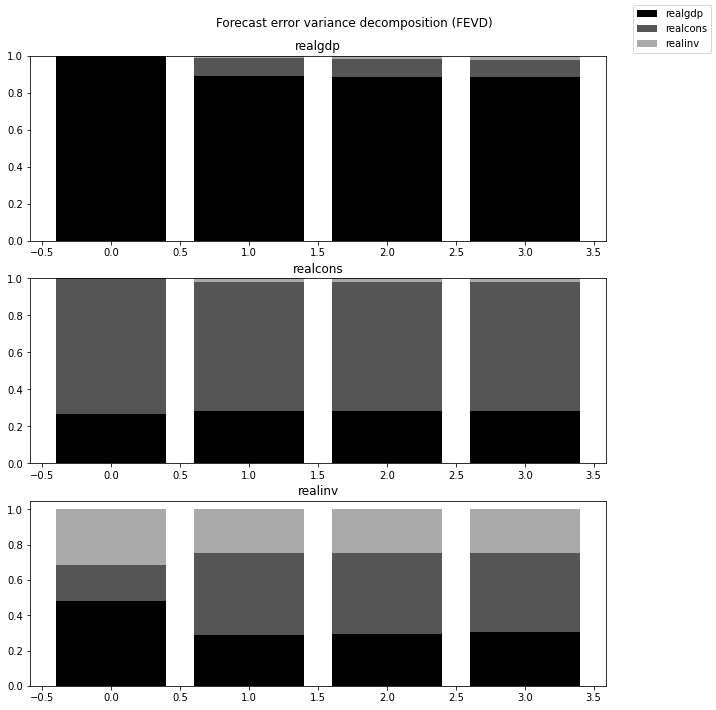

In [130]:
result_diff.fevd(4).plot()
plt.show()

## 2.9 因果性の検証 -- グレンジャー因果

他系列の特徴量も考慮したときのほうがモデルの予測性能が上がる場合、そのほか系列の特徴量から元系列に対してのグレンジャー因果性が存在する。

単位根VAR過程はグレンジャー因果性検定が効かない。  
グレンジャー因果性検定だと、関係の強さを測ることはできない。  
関係の強さを測る道具として、  
- **インパルス応答関数**  
- **分散分解**

が存在する。

2変量VAR(2)モデルを用いてグレンジャー因果性の説明をする。  

$$
y_{1t} = c_1 + \phi_{11}^{(1)} y_{1, t-1} + \phi_{12}^{(1)}y_{2, t-1} + \phi_{11}^{(2)}y_{1, t-2} + \phi_{12}^{(2)}y_{2, t-2} + \epsilon_{1t} \\
y_{2t} = c_2 + \phi_{21}^{(1)} y_{1, t-1} + \phi_{22}^{(1)}y_{2, t-1} + \phi_{21}^{(2)}y_{1, t-2} + \phi_{22}^{(2)}y_{2, t-2} + \epsilon_{2t} \\
$$

検定の進め方。  

帰無仮説 $H_0$ : $\phi_{12}^{(1)} = \phi_{12}^{(2)} = 0$

$$
y_{1t} = c_1 + \phi_{11}^{(1)} y_{1, t-1} + \phi_{12}^{(1)}y_{2, t-1} + \phi_{11}^{(2)}y_{1, t-2} + \phi_{12}^{(2)}y_{2, t-2} + \epsilon_{1t} \\
$$
をOLSで推定し、その残差平方和を $SSR_1$ とする。次に、制約($\phi_{12}^{(1)} = \phi_{12}^{(2)} = 0$ を課したモデル。  

$$
y_{1t} = c_1 + \phi_{11}^{(1)} y_{1, t-1} + \phi_{11}^{(2)}y_{1, t-2}  + \epsilon_{1t} \\
$$
をOLSで推定。その残差平方和を $SSR_0$ とする。このとき、 $SSR_1$ が $SSR_0$ のときよりも小さい値になっていれば因果性が認められる。   
F検定値は  

$$
F \equiv \frac{(SSR_0 - SSR_1)/2}{SSR_1 / (T-5)}
$$

$T$: 標本数

2Fの値が自由度２のカイ二乗分布であるところの $\chi^2(2)$の95%点と比較して、2Fの方が大きければ $y_{2t} \to y_{1t}$ のグレンジャー因果性が存在しないという帰無仮説を棄却し、 $y_{2t}$ は有用であると判断できる。  

注意点:  
グレンジャー因果性があるからといって、通常の因果性が存在するとは限らない。(必要条件ではあるが、十分条件ではない)  

定義どおりに、予測に有用かどうかという観点で捉えるのが一番良い。  

In [131]:
import statsmodels as sm
from statsmodels.tsa.api import VAR

df_data = sm.api.datasets.macrodata.load_pandas().data
df_data.index = pd.date_range('1959', periods=df_data.shape[0], freq='Q')

# 必要なカラムのみを取得
y = df_data[['realgdp', 'realcons', 'realinv']]
# 2次階差をとり定常過程にする
y_diff = y.diff().diff().dropna()
# モデルの作成
model_diff = VAR(y_diff)
result_diff = model_diff.fit(maxlags=10, ic='aic')

In [132]:
from copy import deepcopy

var_names = ['realgdp', 'realinv', 'realcons']

for i in range(len(var_names)):
    vs = deepcopy(var_names)
    print(result_diff.test_causality(vs.pop(i), vs, kind='f').summary())

Granger causality F-test. H_0: %s do not Granger-cause realgdp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.964          1.625   0.000 (18, 492)
-----------------------------------------------
Granger causality F-test. H_0: %s do not Granger-cause realinv. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         6.364          1.625   0.000 (18, 492)
-----------------------------------------------
Granger causality F-test. H_0: %s do not Granger-cause realcons. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.395          1.625   0.001 (18, 492)
-----------------------------------------------


上の３つは全て、グレンジャー因果性があるという結果になっている。

In [134]:
var_names = ['realgdp', 'realinv', 'realcons']

for i in range(len(var_names)):
    vs = deepcopy(var_names)
    tv = vs.pop(i)
    for v in vs:
        print(result_diff.test_causality(tv, v, kind='f').summary())

Granger causality F-test. H_0: realinv does not Granger-cause realgdp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.026          1.899   0.418 (9, 492)
----------------------------------------------
Granger causality F-test. H_0: realcons does not Granger-cause realgdp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.306          1.899   0.000 (9, 492)
----------------------------------------------
Granger causality F-test. H_0: realgdp does not Granger-cause realinv. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.024          1.899   0.419 (9, 492)
----------------------------------------------
Granger causality F-test. H_0: realcons does not Granger-ca

## 2.10 見せかけの回帰

**Engle-Granger共和分検定** を使う

共和分とは  
$x_t$と$y_t$ が単位根(I(1))過程とする。  
$ax_t + by_t$がI(0)となるようなa,bの組が存在するとき、$x_t$と$y_t$との間には共和分の関係があるという。

階差をとると、相関があるデータに対して相関がない、という判断がされることがあるため、 **共和分検定** をしておく必要がある。

In [135]:
from datetime import datetime 
import pandas_datareader.data as web

st = datetime(2017, 1, 1)
end = datetime(2017, 10, 31)
y = web.DataReader('SNE', 'yahoo', start=st, end=end)
y.head()

/Users/oharasoh/study/time_series_analysis/venv/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,28.320000,28.040001,28.100000,28.290001,894900.0,27.775928
2017-01-04,28.660000,28.420000,28.480000,28.580000,910500.0,28.060661
2017-01-05,28.790001,28.430000,28.540001,28.719999,1027500.0,28.198118
2017-01-06,29.040001,28.530001,28.570000,28.959999,964800.0,28.433754
2017-01-09,28.950001,28.740000,28.740000,28.820000,648700.0,28.296301


In [136]:
from statsmodels.tsa import stattools

# y.Closeの値に対してADF検定
ctt = stattools.adfuller(y.Close, regression='ctt')
ct = stattools.adfuller(y.Close, regression='ct')
c = stattools.adfuller(y.Close, regression='c')
nc = stattools.adfuller(y.Close, regression='nc')

print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-1.7430362995571684, 0.89772452893175, 1, 208, {'1%': -4.42770753779568, '5%': -3.8610846253947146, '10%': -3.5709836356350633}, 306.40085884898934)
ct:
(-2.202596466390707, 0.48838926772988817, 1, 208, {'1%': -4.002966509244673, '5%': -3.43181159172131, '10%': -3.139573978276485}, 304.6027052661152)
c:
(-0.8138677943630346, 0.8150145292024809, 1, 208, {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}, 306.56290529746735)
nc:
(1.6761397940114557, 0.9776209940954025, 1, 208, {'1%': -2.5765728725961536, '5%': -1.942365654803603, '10%': -1.615602989499175}, 305.0634077469417)


In [138]:
from statsmodels.api import OLS
x_factor = np.random.randn(len(y)).cumsum()
model = OLS(y.Close, x_factor)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.072
Model:                            OLS   Adj. R-squared (uncentered):              0.068
Method:                 Least Squares   F-statistic:                              16.32
Date:                Sat, 18 Apr 2020   Prob (F-statistic):                    7.53e-05
Time:                        17:11:39   Log-Likelihood:                         -1040.9
No. Observations:                 210   AIC:                                      2084.
Df Residuals:                     209   BIC:                                      2087.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1382      0.777      4.039      0.000       1.607       4.670
==============================================================================
Omnibus:                        4.418   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                2.986
Skew:                           0.117   Prob(JB):                        0.225
Kurtosis:                       2.464   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

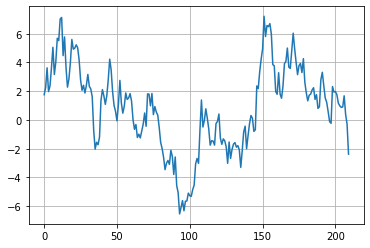

In [140]:
plt.plot(x_factor)
plt.grid()

In [141]:
# ADF検定

# y.Closeの値に対してADF検定
ctt = stattools.adfuller(x_factor, regression='ctt')
ct = stattools.adfuller(x_factor, regression='ct')
c = stattools.adfuller(x_factor, regression='c')
nc = stattools.adfuller(x_factor, regression='nc')

print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

ctt:
(-2.573786885655683, 0.526904561887964, 0, 209, {'1%': -4.4274325368239005, '5%': -3.860945830959756, '10%': -3.5708981838796694}, 544.9785893499084)
ct:
(-2.431096864181531, 0.36322175531078527, 0, 209, {'1%': -4.0027517721652925, '5%': -3.4317085320958416, '10%': -3.139513599307244}, 542.9854819720847)
c:
(-2.4255128233031003, 0.13466468728416875, 0, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 541.0857584724381)
nc:
(-2.4079449850497547, 0.015474180635896145, 0, 209, {'1%': -2.576520641468831, '5%': -1.942358783170154, '10%': -1.6156085405816791}, 539.0937990942364)
